<a href="https://colab.research.google.com/github/eldapere8/berkeley/blob/main/Causal_Inference_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Causal Inference and Prediction of Major Depressive Disorder Diagnoses in the Collaborative Psychiatric Epidemiology Surveys



Elda Pere, Kathleen Navas, Lauren Santilli, Rosey Stone

## ✏️ Data and Library Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import (drive, files)
from sklearn.linear_model import LogisticRegression
from matplotlib.gridspec import GridSpec

In [2]:
import os
path = "/content/gdrive"
drive.mount(path, force_remount=True)
os.chdir(path)

Mounted at /content/gdrive


In [3]:
filepath = 'MyDrive/Data C102 Project/'

first_df = pd.read_csv(path+"/"+filepath+'20240-0001-Data.tsv', sep='\t')
first_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,10,11,12,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,36,37,40,41,43,44,45,46,47,48,50,51,55,56,62,65,66,67,68,69,70,71,75,81,86,87,88,89,92,93,94,572,864,937,938,972,973,975,977,979,980,993,996,1000,1004,1006,1008,1156,1242,1266,1271,1294,1493,1494,1495,1498,1499,1500,1501,1502,1503,1508,1509,1510,1511,1512,1514,1515,1516,1517,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528,1529,1530,1531,1590,1591,1592,1593,1594,1614,1656,1658,1662,1849,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1960,1961,1971,1972,1973,1974,1975,1976,1977,1978,1979,1981,1982,1983,1984,1985,2014,2026,2028,2029,2030,2031,2032,2040,2041,2042,2043,2045,2046,2047,2048,2064,2065,2066,2067,2069,2071,2073,2074,2077,2078,2079,2080,2083,2084,2085,2088,2094,2099,2104,2111,2120,2121,2122,2123,2124,2136,2137,2138,2139,2141,2142,2143,2144,2146,2148,2167,2203,2218,2258,2259,2288,2291

,CASEID,V07312,V07319,V07320,V09154,V08825,V07477,V07292,V07297,V08249,V09346,V09218,V06442,V06443,V06444,V06441,V06445,V06446,V00232,V00233,V00234,V00239,V00252,V00253,V00254,V00255,V00256,V00257,V00264,V00265,V00266,V00267,V00745,V00248,V00249,V00251,V00683,V00684,V00688,V00689,...,V09424,V09425,V09426,V09427,V09428,V09429,V09430,V09431,V09432,V09433,V09434,V07557,V07561,V07726,V08518,V08519,V08551,V08552,V08323,V08325,V08324,V08326,V08375,V08378,V08497,V08217,V09435,V06376,V05239,V05240,V04611,NCSRWTSH,NCSRWTLG,NCNSWTSH,NCNSWTLG,NCNLWTSH,NCNLWTLG,NSNLWT,CPESWTSH,CPESWTLG
0,1,,,,1,2,0,0,2,2,3,3,1,,,1,,1,3,3,3,0,5,5,5,5,5,5,5,5,5,5,1,,,,1,5,5,5,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,11627.4,14040.7,15969,11627.3949,14040.6
1,2,,,,1,2,0,0,1,1,3,3,1,,,1,,1,3,3,1,0,5,5,5,5,5,5,5,5,5,5,2,,,,1,5,5,5,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,10090.9,12185.2,13858.7,10090.8613,12185.2
2,3,,,,3,2,0,0,1,1,3,1,1,,,1,,1,3,3,2,0,5,5,5,5,5,5,5,5,5,5,1,,,,1,1,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,10090.9,12185.2,13858.7,10090.8613,12185.2
3,4,,,,1,9,0,0,2,2,0,0,8,4,,1,,1,2,2,1,0,5,5,5,5,5,5,5,5,5,5,1,,,,1,1,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,5939.81,6525.43,7919.74,5939.8017,6525.42
4,5,,,,1,6,0,0,1,1,0,0,8,4,,1,,1,3,1,1,0,5,5,5,5,5,5,5,5,5,5,2,,,,1,5,5,5,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,4572.45,5023.26,6096.6,4572.4457,5023.25


## 📊 Exploratory Data Analysis




In [4]:
first_df.isnull().values.any()

False

In [5]:
first_df.isnull().sum().sum()

0

Choosing variables corresponding to survey responses about depression diagnosis and factors that may affect it. 

Link to codebook with questions corresponding to their variable number: 
https://doi.org/10.3886/ICPSR20240.v8 

In [6]:
treatment_vars = ['V05874', 'V05875', 'V05876', 'V05894']
outcome_var = 'V07876'
confounder_vars = ['V05795', 'V05879', 'V05884', 'V06929', 'V06932', 'RANCEST', 'V08992', 'V07306', 'V08683', 'V03080', 'V03081']
iv = 'V05899'

In [7]:
second_df = first_df[treatment_vars + [outcome_var] + confounder_vars + [iv]].iloc[:-1]
second_df.shape

(20012, 17)

In [8]:
second_df.head()

,V05874,V05875,V05876,V05894,V07876,V05795,V05879,V05884,V06929,V06932,RANCEST,V08992,V07306,V08683,V03080,V03081,V05899
0,,,,,5,,,,,,4,1,36,105000,,,
1,,,,,5,,,,,,4,1,34,109500,,,
2,,,,,5,,,,,,4,1,28,44299,,,
3,,,,,1,,,,,,6,1,50,200000,,,
4,,,,,5,,,,,,6,1,53,74999,,,


In [9]:
# Filter for respondents who have a non-null answer for race
eda_df = second_df[second_df['RANCEST'] > 0]
eda_df.shape

(20012, 17)

In [10]:
eda_df['dummy'] = 1
eda_df = eda_df[['RANCEST','dummy']]
title_type = eda_df.groupby('RANCEST').agg('count')
title_type.head()

,dummy
RANCEST,
1,520
2,508
3,600
4,656
5,577


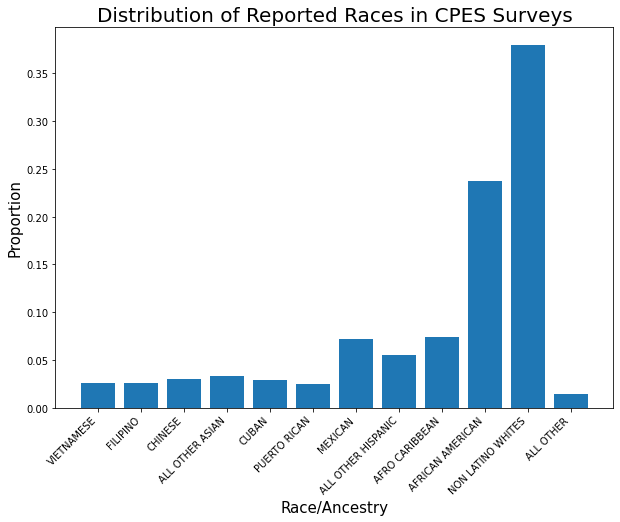

In [11]:
# Bar chart to visualize distribution of races in data 

type_labels = ['VIETNAMESE','FILIPINO','CHINESE','ALL OTHER ASIAN','CUBAN','PUERTO RICAN','MEXICAN','ALL OTHER HISPANIC','AFRO CARIBBEAN','AFRICAN AMERICAN','NON LATINO WHITES','ALL OTHER'] 
title_type['prop'] = title_type['dummy']/sum(title_type['dummy'])
plt.figure(figsize=(10,7)) 
plt.title('Distribution of Reported Races in CPES Surveys', size=20)
plt.xlabel('Race/Ancestry', size = 15)
plt.ylabel('Proportion', size = 15)
plt.xticks(rotation = 45, ha='right')
char = plt.bar(x=type_labels, height=title_type['prop']);

In [12]:
# Filter out individuals who's responses were invalid, i.e. age should be above 17 to be considered an adult

eda_2 = second_df[(second_df['V07306'] > 17)]
eda_2 = eda_2[['V07306']]
eda_2.head()

,V07306
0,36
1,34
2,28
3,50
4,53


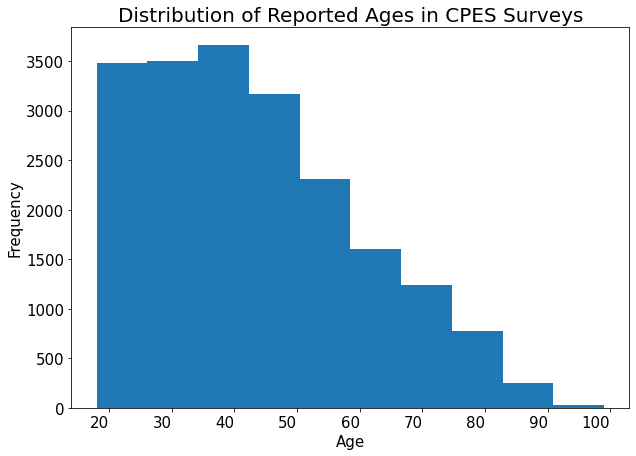

In [13]:
# Histogram displaying distribution of respondents ages

plt.figure(figsize=(10,7)) 
plt.title('Distribution of Reported Ages in CPES Surveys', size=20)
plt.xlabel('Age', size = 15)
plt.ylabel('Frequency', size = 15)
plt.yticks(size=15, ha='right')
plt.xticks(size=15, ha='right')
plt.hist(eda_2['V07306']);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


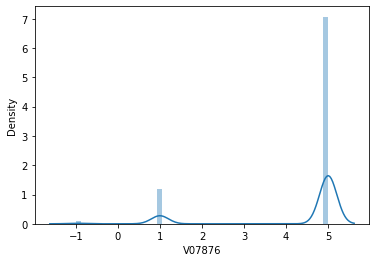

In [14]:
sns.distplot(second_df['V07876'].replace(' ', -1).astype(int));

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


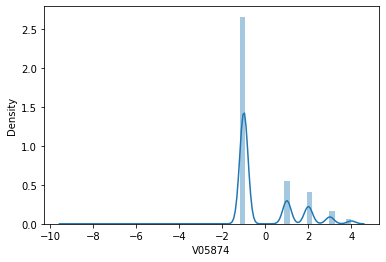

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


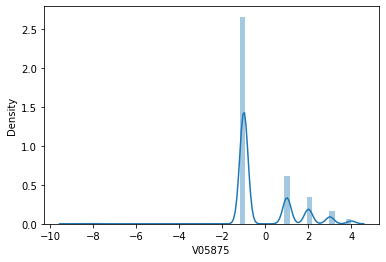

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


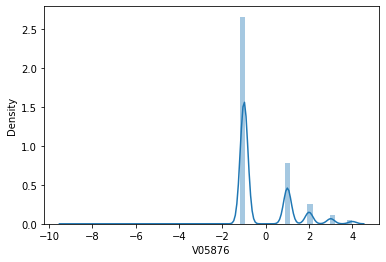

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


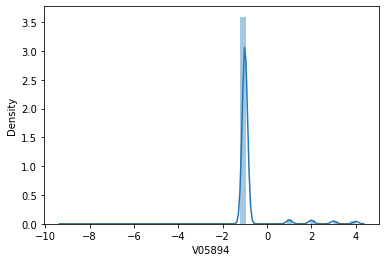

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


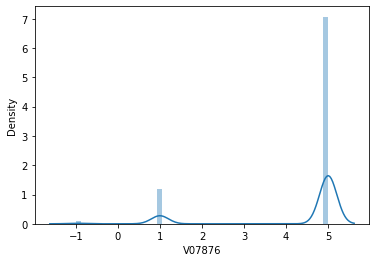

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


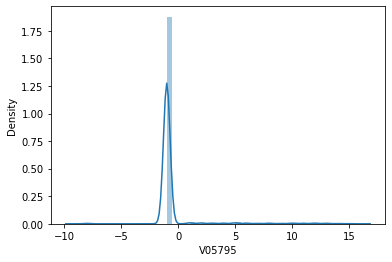

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


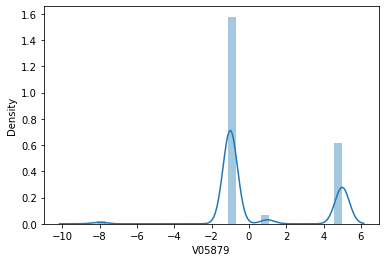

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


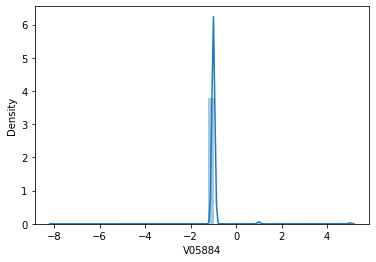

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


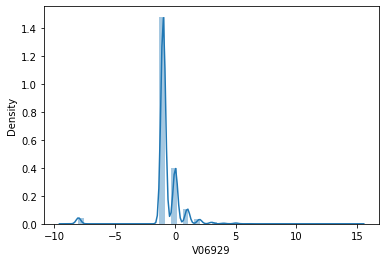

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


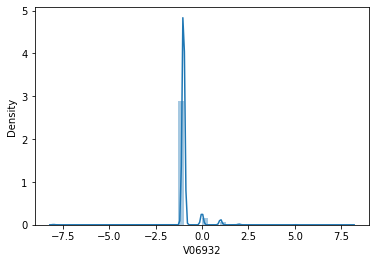

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


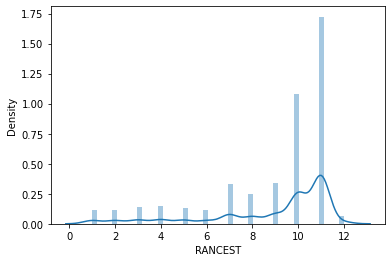

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


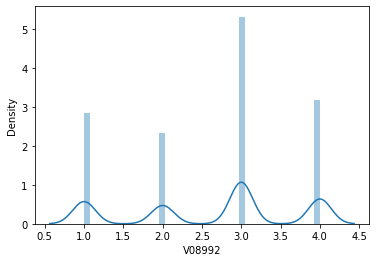

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


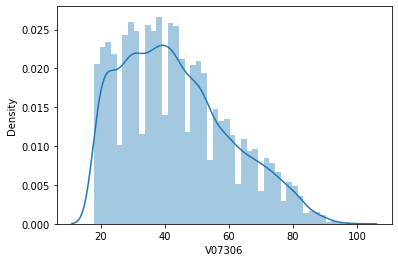

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


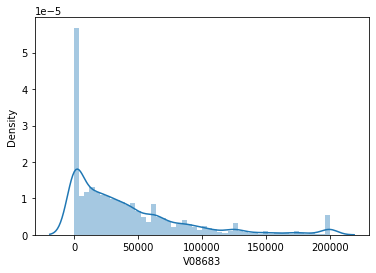

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


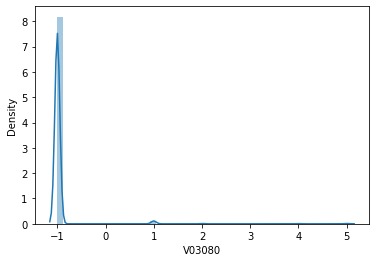

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


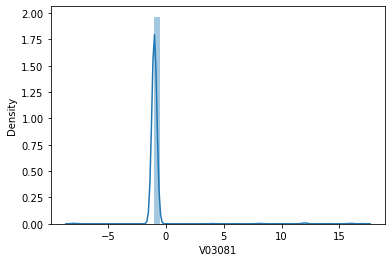

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


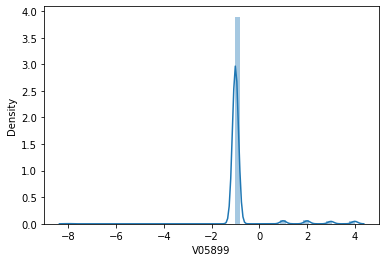

In [15]:
for column in second_df.columns:
    sns.distplot(second_df[column].replace(' ', -1).astype(int));
    plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Participant Household Income Distribution, Capped at 200K')

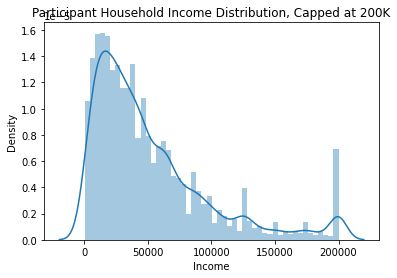

In [16]:
visual_income = second_df[['V08683']].replace(' ', -1).astype(int)
sns.distplot(visual_income[visual_income['V08683']>0]);
plt.xlabel('Income');
plt.title('Participant Household Income Distribution, Capped at 200K')

In [17]:
# Remove the following unneeded columns: V05894, V05884, V06932, V03080, V03081
third_df = second_df.drop(columns = ['V05894', 'V05884', 'V06932', 'V03080', 'V03081'], axis = 1)
third_df = third_df.replace(' ', -1).astype(int)
third_df = third_df[third_df['V07876'] > -1]
third_df.head()

,V05874,V05875,V05876,V07876,V05795,V05879,V06929,RANCEST,V08992,V07306,V08683,V05899
0,-1,-1,-1,5,-1,-1,-1,4,1,36,105000,-1
1,-1,-1,-1,5,-1,-1,-1,4,1,34,109500,-1
2,-1,-1,-1,5,-1,-1,-1,4,1,28,44299,-1
3,-1,-1,-1,1,-1,-1,-1,6,1,50,200000,-1
4,-1,-1,-1,5,-1,-1,-1,6,1,53,74999,-1


In [18]:
third_df = third_df.rename(columns = {'V07876': 'Major_Depressive_Disorder', 'V05874': 'How_Emotionally_Close_With_Father', 
                          'V05875': 'How_Much_Love_Man_Gave', 'V05876': 'How_Much_Effort_In_Upbringing',
                          'V05795': 'Parent_Divorce_Status', 'V05879': 'FatherMan_+2Weeks_Sadness', 
                          'V06929': 'Num_Close_Relatives_With_Depression', 'V08992': 'Region', 
                           'V07306': 'Age', 'V08683': 'Income', 'RANCEST': 'Race/Ancestry', 
                                      'V05899': 'Father_Sub_Interfere_Growing_Up'})
third_df.head()

,How_Emotionally_Close_With_Father,How_Much_Love_Man_Gave,How_Much_Effort_In_Upbringing,Major_Depressive_Disorder,Parent_Divorce_Status,FatherMan_+2Weeks_Sadness,Num_Close_Relatives_With_Depression,Race/Ancestry,Region,Age,Income,Father_Sub_Interfere_Growing_Up
0,-1,-1,-1,5,-1,-1,-1,4,1,36,105000,-1
1,-1,-1,-1,5,-1,-1,-1,4,1,34,109500,-1
2,-1,-1,-1,5,-1,-1,-1,4,1,28,44299,-1
3,-1,-1,-1,1,-1,-1,-1,6,1,50,200000,-1
4,-1,-1,-1,5,-1,-1,-1,6,1,53,74999,-1


## ⚙️ Feature Engineering

In [19]:
#Making parent divorce status binary

def func(x):
    b = x ==(-8)
    c = x ==(-9)
    if b or c:
        return 0
    elif x != -1:
        return 1
third_df['Parent_Divorce_status'] = third_df[['Parent_Divorce_Status']].applymap(func)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


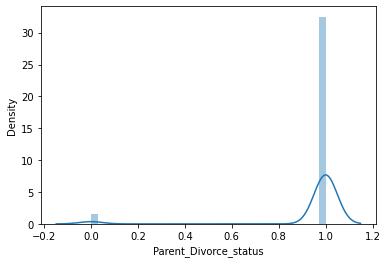

In [20]:
sns.distplot(third_df['Parent_Divorce_status'])

In [21]:
third_df['Major_Depressive_Disorder'] = third_df[['Major_Depressive_Disorder']].replace(5, 0)

In [22]:
third_df['How_Emotionally_Close_With_Father'] = third_df[['How_Emotionally_Close_With_Father']].replace([-8,-9], -1)

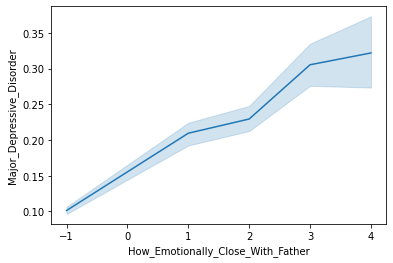

In [23]:
#note: how close with father -and other treatment vars -(1 = very close, 4 = not close)

sns.lineplot(x = 'How_Emotionally_Close_With_Father', y = 'Major_Depressive_Disorder', data = third_df)

In [24]:
third_df['How_Much_Love_Man_Gave'] = third_df[['How_Much_Love_Man_Gave']].replace([-8,-9], -1)

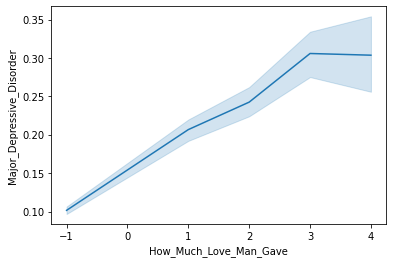

In [25]:
sns.lineplot(x = 'How_Much_Love_Man_Gave', y = 'Major_Depressive_Disorder', data = third_df)

In [26]:
third_df['How_Much_Effort_In_Upbringing'] = third_df[['How_Much_Effort_In_Upbringing']].replace([-8,-9], -1)

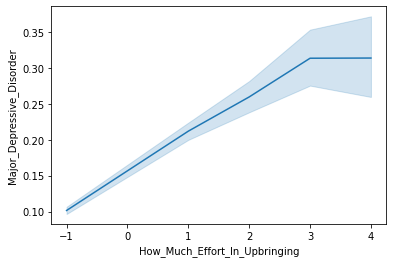

In [27]:
sns.lineplot(x = 'How_Much_Effort_In_Upbringing', y = 'Major_Depressive_Disorder', data = third_df)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


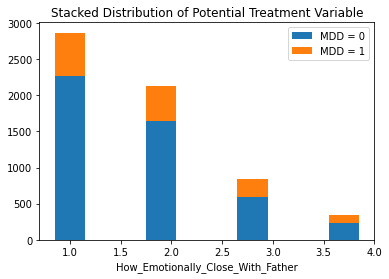

In [28]:
#stacked histograms for first treatment var 
dep_0 = third_df['How_Emotionally_Close_With_Father'][(third_df['Major_Depressive_Disorder'] == 0) & (third_df['How_Emotionally_Close_With_Father']>0)]
dep_1 = third_df['How_Emotionally_Close_With_Father'][(third_df['Major_Depressive_Disorder'] == 1) & (third_df['How_Emotionally_Close_With_Father']>0)]

plt.hist([dep_0, dep_1], stacked = True, align='left');
plt.legend(['MDD = 0', 'MDD = 1']);
plt.xlabel('How_Emotionally_Close_With_Father');
plt.title('Stacked Distribution of Potential Treatment Variable')
plt.rcParams["figure.figsize"] = (10,8)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


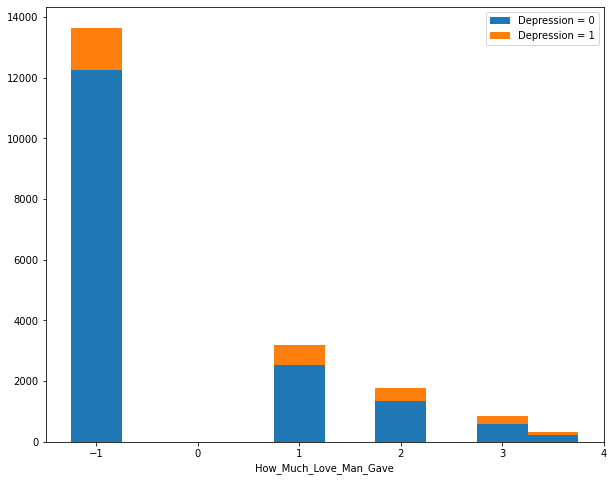

In [29]:

dep_00 = third_df['How_Much_Love_Man_Gave'][third_df['Major_Depressive_Disorder'] == 0]
dep_11 = third_df['How_Much_Love_Man_Gave'][third_df['Major_Depressive_Disorder'] == 1]

plt.hist([dep_00, dep_11], stacked = True, align='left');
plt.legend(['Depression = 0', 'Depression = 1']);
plt.xlabel('How_Much_Love_Man_Gave');

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


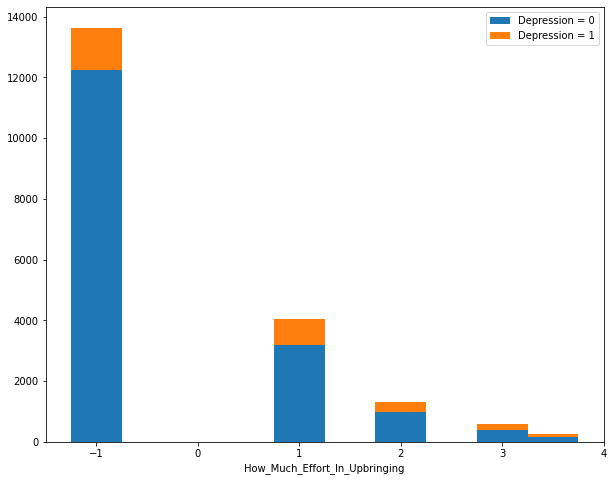

In [30]:

dep_000 = third_df['How_Much_Effort_In_Upbringing'][third_df['Major_Depressive_Disorder'] == 0]
dep_111 = third_df['How_Much_Effort_In_Upbringing'][third_df['Major_Depressive_Disorder'] == 1]

plt.hist([dep_000, dep_111], stacked = True, align='left');
plt.legend(['Depression = 0', 'Depression = 1']);
plt.xlabel('How_Much_Effort_In_Upbringing');

## Research Question 1

## Research Question 2
Does a poor relationship with a father figure cause a depression diagnosis in adults in the contiguous US?

# [Option D] Casual Inference Analysis



Missing values: getting rid of all rows without valid responses for each variable.

In [31]:
unconf_df = third_df[third_df['Major_Depressive_Disorder'] >-1]
unconf_df = unconf_df[unconf_df['How_Emotionally_Close_With_Father'] >-1]
unconf_df = unconf_df[unconf_df['How_Much_Love_Man_Gave'] >-1]
unconf_df = unconf_df[unconf_df['How_Much_Effort_In_Upbringing'] >-1]
unconf_df = unconf_df[unconf_df['Income'] >-1]

unconf_df.shape

(5284, 13)

Turning main categorical treatment variables into binary variables: values of 1 and 2 are translated into a value of 0 (not a poor relationship with father) and 1 (poor relationship with father). 

In [32]:
def bin_func(x):
    b = x == 1
    c = x == 2
    if b or c:
        return 0
    else:
        return 1

unconf_df['How_Emotionally_Close_With_Father'] = unconf_df[['How_Emotionally_Close_With_Father']].applymap(bin_func)
unconf_df['How_Much_Love_Man_Gave'] = unconf_df[['How_Much_Love_Man_Gave']].applymap(bin_func)
unconf_df['How_Much_Effort_In_Upbringing'] = unconf_df[['How_Much_Effort_In_Upbringing']].applymap(bin_func)
unconf_df.head()

,How_Emotionally_Close_With_Father,How_Much_Love_Man_Gave,How_Much_Effort_In_Upbringing,Major_Depressive_Disorder,Parent_Divorce_Status,FatherMan_+2Weeks_Sadness,Num_Close_Relatives_With_Depression,Race/Ancestry,Region,Age,Income,Father_Sub_Interfere_Growing_Up,Parent_Divorce_status
4649,0,0,0,1,-1,5,-1,8,1,41,125500,-1,NaN
4651,0,1,0,0,-1,5,-1,11,1,79,15500,-1,NaN
4655,0,0,0,0,-1,5,-1,11,1,30,150000,-1,NaN
4656,0,0,0,0,-1,5,-1,11,1,65,40500,-1,NaN
4661,0,0,0,0,-1,5,-1,10,1,47,9000,-1,NaN


Annual poverty line in the US in 2002 for a household of 4 individuals was 18,100 and 8,860 for a household of 1 individual, so engineered relevent features based on income data:

  1) binary variable 'In_Poverty_1' where reporting an income below the poverty line for a household of four, results in a value of 1, indicating that one is living in poverty.
  
  2) variable 'In_Poverty_2' where reporting an income below the poverty line for a household of one, results in a value of 1, indicating that one is living in poverty.   

Poverty lines from source: https://aspe.hhs.gov/prior-hhs-poverty-guidelines-and-federal-register-references

In [33]:
def in_pov1(x):
  if x > 18100:
    return 0
  elif x > -1:
    return 1

def in_pov2(x):
  if x > 8860:
    return 0
  elif x >= 0:
    return 1

unconf_df['In_Poverty1'] = unconf_df[['Income']].astype(int).applymap(in_pov1)
unconf_df['In_Poverty2'] = unconf_df[['Income']].astype(int).applymap(in_pov2)
unconf_df.head()

,How_Emotionally_Close_With_Father,How_Much_Love_Man_Gave,How_Much_Effort_In_Upbringing,Major_Depressive_Disorder,Parent_Divorce_Status,FatherMan_+2Weeks_Sadness,Num_Close_Relatives_With_Depression,Race/Ancestry,Region,Age,Income,Father_Sub_Interfere_Growing_Up,Parent_Divorce_status,In_Poverty1,In_Poverty2
4649,0,0,0,1,-1,5,-1,8,1,41,125500,-1,NaN,0,0
4651,0,1,0,0,-1,5,-1,11,1,79,15500,-1,NaN,1,0
4655,0,0,0,0,-1,5,-1,11,1,30,150000,-1,NaN,0,0
4656,0,0,0,0,-1,5,-1,11,1,65,40500,-1,NaN,0,0
4661,0,0,0,0,-1,5,-1,10,1,47,9000,-1,NaN,1,0


### Proof of Unconfoundedness with Income/Poverty Status

Z_i corresponds to whether the participant i had 0 or 1 relationship with fatherman.  <br>
Y_i(0) and Y_i(1) represent what-ifs: if participant i had relationship 0 or 1 with fatherman, would they get depression?

In [34]:
# Prove unconfoundness by showing:
# E [Y(1) | Z=1, X=x] = E [Y(1) | X=x]
# Reference: lecture 15 whiteboard notes 


def condfoundness(df, treat_ind, out_ind, conf_ind):
  # 1 * (P(Y=1 | Z=1, X=1) + P(Y=1 | Z=1, X=0))
  exp_1 =  1 * ((len(df[(df[out_ind] == 1) & (df[treat_ind] == 1) & (df[conf_ind] == 1)]) /
                 len(df[(df[treat_ind] == 1) & (df[conf_ind] == 1)])) +
                (len(df[(df[out_ind] == 1) & (df[treat_ind] == 1) & (df[conf_ind] == 0)]) /
                 len(df[(df[treat_ind] == 1) & (df[conf_ind] == 0)])))
  exp_2 = 1 * ((len(df[(df[out_ind] == 1) & (df[conf_ind] == 1)]) / 
                len(df[df[conf_ind] == 1])) + 
               (len(df[(df[out_ind] == 1) & (df[conf_ind] == 0)]) / 
                len(df[df[conf_ind] == 0])))
  return np.abs(exp_1 - exp_2)

In [35]:
# If unconfoundness assumption holds, result should be zero

# 'In_Poverty1'
diff = condfoundness(unconf_df, 'How_Emotionally_Close_With_Father', 'Major_Depressive_Disorder', 'In_Poverty1')
diff1 = condfoundness(unconf_df, 'How_Much_Love_Man_Gave', 'Major_Depressive_Disorder', 'In_Poverty1')
diff2 = condfoundness(unconf_df, 'How_Much_Effort_In_Upbringing', 'Major_Depressive_Disorder', 'In_Poverty1')
# 'In_Poverty2'
diff3 = condfoundness(unconf_df, 'How_Emotionally_Close_With_Father', 'Major_Depressive_Disorder', 'In_Poverty2')
diff4 = condfoundness(unconf_df, 'How_Much_Love_Man_Gave', 'Major_Depressive_Disorder', 'In_Poverty2')
diff5 = condfoundness(unconf_df, 'How_Much_Effort_In_Upbringing', 'Major_Depressive_Disorder', 'In_Poverty2')

print('In_Poverty1 :', diff, diff1, diff2)
print('In_Poverty2 :', diff3, diff4, diff5)

In_Poverty1 : 0.09986584912600693 0.08801669948238056 0.09347507645639175
In_Poverty2 : 0.11007805624562794 0.11357832170861093 0.08572957360486766


### Simpson's Paradox

In [36]:
#For Poverty1:
y0_z0 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] == 0) & (unconf_df['Major_Depressive_Disorder'] == 0)]
y1_z1 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] == 1) & (unconf_df['Major_Depressive_Disorder'] == 1)]
y0_z0_x1 = y0_z0[y0_z0['In_Poverty1'] == 1]
y0_z0_x0 = y0_z0[y0_z0['In_Poverty1'] == 0]
y1_z1_x1 = y1_z1[y1_z1['In_Poverty1'] == 1]
y1_z1_x0 = y1_z1[y1_z1['In_Poverty1'] == 0]

#for denominators in following cells: (maybe not)
z0_x1 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] == 0) & (unconf_df['In_Poverty1'] == 1)]
z0_x0 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] == 0) & (unconf_df['In_Poverty1'] == 0)]
z1_x1 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] == 1) & (unconf_df['In_Poverty1'] == 1)]
z1_x0 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] == 1) & (unconf_df['In_Poverty1'] == 0)]
z0 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] ==0)]
z1 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] ==1)]


#verify:
len(z1_x0) + len(z1_x1) == len(z1)

True

In [37]:
#For Poverty1:
print('E[y(0)|Z=0] = ' + str(len(y0_z0)/len(unconf_df)))
print('E[y(1)|Z=1] = ' + str(len(y1_z1)/len(unconf_df)))
print('The prima facie causal effect is E[y(1)|Z=1] - E[y(0)|Z=0] = ' + str(len(y1_z1)/len(unconf_df) - len(y0_z0)/len(unconf_df)))

E[y(0)|Z=0] = 0.5881907645722937
E[y(1)|Z=1] = 0.0694549583648751
The prima facie causal effect is E[y(1)|Z=1] - E[y(0)|Z=0] = -0.5187358062074185


In [38]:
#print table:
print('        ' + 'Y = 0 | Z = 0 '+ '    Y = 1 | X = 1')
print('X = 1      ' + str(round(len(y0_z0_x1)/len(z0_x1), 2)) + '              ' + str(round(len(y1_z1_x1)/len(z1_x1), 2)))
print('X = 0      ' + str(round(len(y0_z0_x0)/len(z0_x0), 2)) + '              ' + str(round(len(y1_z1_x0)/len(z1_x0), 2)))
print('Total      ' + str(round(len(y0_z0)/len(z0), 2)) + '              ' + str(round(len(y1_z1)/len(z1), 2)))

        Y = 0 | Z = 0     Y = 1 | X = 1
X = 1      0.74              0.3
X = 0      0.74              0.34
Total      0.74              0.34


Simpson's Paradox is not present for Poverty1.

In [39]:
#For Poverty2:
y0_z0 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] == 0) & (unconf_df['Major_Depressive_Disorder'] == 0)]
y1_z1 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] == 1) & (unconf_df['Major_Depressive_Disorder'] == 1)]
y0_z0_x1 = y0_z0[y0_z0['In_Poverty2'] == 1]
y0_z0_x0 = y0_z0[y0_z0['In_Poverty2'] == 0]
y1_z1_x1 = y1_z1[y1_z1['In_Poverty2'] == 1]
y1_z1_x0 = y1_z1[y1_z1['In_Poverty2'] == 0]

#for denominators in following cells: (maybe not)
z0_x1 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] == 0) & (unconf_df['In_Poverty2'] == 1)]
z0_x0 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] == 0) & (unconf_df['In_Poverty2'] == 0)]
z1_x1 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] == 1) & (unconf_df['In_Poverty2'] == 1)]
z1_x0 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] == 1) & (unconf_df['In_Poverty2'] == 0)]
z0 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] ==0)]
z1 = unconf_df[(unconf_df['How_Emotionally_Close_With_Father'] ==1)]


#verify:
len(z1_x0) + len(z1_x1) == len(z1)

True

In [40]:
#For Poverty2:
print('E[y(0)|Z=0] = ' + str(len(y0_z0)/len(unconf_df)))
print('E[y(1)|Z=1] = ' + str(len(y1_z1)/len(unconf_df)))
print('The prima facie causal effect is E[y(1)|Z=1] - E[y(0)|Z=0] = ' + str(len(y1_z1)/len(unconf_df) - len(y0_z0)/len(unconf_df)))

E[y(0)|Z=0] = 0.5881907645722937
E[y(1)|Z=1] = 0.0694549583648751
The prima facie causal effect is E[y(1)|Z=1] - E[y(0)|Z=0] = -0.5187358062074185


In [41]:
#print table:
print('        ' + 'Y = 0 | Z = 0 '+ '    Y = 1 | X = 1')
print('X = 1      ' + str(round(len(y0_z0_x1)/len(z0_x1), 2)) + '              ' + str(round(len(y1_z1_x1)/len(z1_x1), 2)))
print('X = 0      ' + str(round(len(y0_z0_x0)/len(z0_x0), 2)) + '              ' + str(round(len(y1_z1_x0)/len(z1_x0), 2)))
print('Total      ' + str(round(len(y0_z0)/len(z0), 2)) + '              ' + str(round(len(y1_z1)/len(z1), 2)))

        Y = 0 | Z = 0     Y = 1 | X = 1
X = 1      0.73              0.33
X = 0      0.74              0.34
Total      0.74              0.34


Simpson's Paradox is still not present. Similar for other treatments because they have similar values.

### CATE (Conditional Average Treament Effect) Calculations

For 'In_Poverty1':

In [42]:
in_poverty = unconf_df[unconf_df['In_Poverty1'] == 1]
in_pov_and_poor_relat_father_fig = in_poverty[in_poverty['How_Emotionally_Close_With_Father'] == 1]
in_pov_wo_poor_relat_father_fig = in_poverty[in_poverty['How_Emotionally_Close_With_Father'] == 0]
not_in_poverty = unconf_df[unconf_df['In_Poverty1'] == 0]
not_in_pov_and_poor_relat_father_fig = not_in_poverty[not_in_poverty['How_Emotionally_Close_With_Father'] == 1]
not_in_pov_wo_poor_relat_father_fig = not_in_poverty[not_in_poverty['How_Emotionally_Close_With_Father'] == 0]
MDD_0_SDO = len(not_in_pov_and_poor_relat_father_fig[not_in_pov_and_poor_relat_father_fig['Major_Depressive_Disorder'] == 1])/len(not_in_pov_and_poor_relat_father_fig) - len(not_in_pov_wo_poor_relat_father_fig[not_in_pov_wo_poor_relat_father_fig['Major_Depressive_Disorder'] == 1])/len(not_in_pov_wo_poor_relat_father_fig)
MDD_1_SDO = len(in_pov_and_poor_relat_father_fig[in_pov_and_poor_relat_father_fig['Major_Depressive_Disorder'] == 1])/len(in_pov_and_poor_relat_father_fig) - len(in_pov_wo_poor_relat_father_fig[in_pov_wo_poor_relat_father_fig['Major_Depressive_Disorder'] == 1])/len(in_pov_wo_poor_relat_father_fig)

CATE_MDD_income = (MDD_1_SDO - MDD_0_SDO)
print(CATE_MDD_income)

-0.04614351693825558


In [43]:
in_pov_and_poor_relat_father_fig1 = in_poverty[in_poverty['How_Much_Love_Man_Gave'] == 1]
in_pov_wo_poor_relat_father_fig1 = in_poverty[in_poverty['How_Much_Love_Man_Gave'] == 0]
not_in_pov_and_poor_relat_father_fig1 = not_in_poverty[not_in_poverty['How_Much_Love_Man_Gave'] == 1]
not_in_pov_wo_poor_relat_father_fig1 = not_in_poverty[not_in_poverty['How_Much_Love_Man_Gave'] == 0]
MDD_0_SDO1 = len(not_in_pov_and_poor_relat_father_fig1[not_in_pov_and_poor_relat_father_fig1['Major_Depressive_Disorder'] == 1])/len(not_in_pov_and_poor_relat_father_fig1) - len(not_in_pov_wo_poor_relat_father_fig1[not_in_pov_wo_poor_relat_father_fig1['Major_Depressive_Disorder'] == 1])/len(not_in_pov_wo_poor_relat_father_fig1)
MDD_1_SDO1 = len(in_pov_and_poor_relat_father_fig1[in_pov_and_poor_relat_father_fig1['Major_Depressive_Disorder'] == 1])/len(in_pov_and_poor_relat_father_fig1) - len(in_pov_wo_poor_relat_father_fig1[in_pov_wo_poor_relat_father_fig1['Major_Depressive_Disorder'] == 1])/len(in_pov_wo_poor_relat_father_fig1)

CATE_MDD_income1 = (MDD_1_SDO1 - MDD_0_SDO1)
print(CATE_MDD_income1)

-0.05801379768729653


In [44]:
in_pov_and_poor_relat_father_fig2 = in_poverty[in_poverty['How_Much_Effort_In_Upbringing'] == 1]
in_pov_wo_poor_relat_father_fig2 = in_poverty[in_poverty['How_Much_Effort_In_Upbringing'] == 0]
not_in_pov_and_poor_relat_father_fig2 = not_in_poverty[not_in_poverty['How_Much_Effort_In_Upbringing'] == 1]
not_in_pov_wo_poor_relat_father_fig2 = not_in_poverty[not_in_poverty['How_Much_Effort_In_Upbringing'] == 0]
MDD_0_SDO2 = len(not_in_pov_and_poor_relat_father_fig2[not_in_pov_and_poor_relat_father_fig2['Major_Depressive_Disorder'] == 1])/len(not_in_pov_and_poor_relat_father_fig2) - len(not_in_pov_wo_poor_relat_father_fig2[not_in_pov_wo_poor_relat_father_fig2['Major_Depressive_Disorder'] == 1])/len(not_in_pov_wo_poor_relat_father_fig2)
MDD_1_SDO2 = len(in_pov_and_poor_relat_father_fig2[in_pov_and_poor_relat_father_fig2['Major_Depressive_Disorder'] == 1])/len(in_pov_and_poor_relat_father_fig2) - len(in_pov_wo_poor_relat_father_fig2[in_pov_wo_poor_relat_father_fig2['Major_Depressive_Disorder'] == 1])/len(in_pov_wo_poor_relat_father_fig2)

CATE_MDD_income2 = (MDD_1_SDO2 - MDD_0_SDO2)
print(CATE_MDD_income2)

-0.058556863383401325


For 'In_Poverty2' :

In [45]:
in_poverty3 = unconf_df[unconf_df['In_Poverty2'] == 1]
in_pov_and_poor_relat_father_fig3 = in_poverty3[in_poverty3['How_Emotionally_Close_With_Father'] == 1]
in_pov_wo_poor_relat_father_fig3 = in_poverty3[in_poverty3['How_Emotionally_Close_With_Father'] == 0]
not_in_poverty3 = unconf_df[unconf_df['In_Poverty2'] == 0]
not_in_pov_and_poor_relat_father_fig3 = not_in_poverty3[not_in_poverty3['How_Emotionally_Close_With_Father'] == 1]
not_in_pov_wo_poor_relat_father_fig3 = not_in_poverty3[not_in_poverty3['How_Emotionally_Close_With_Father'] == 0]
MDD_0_SDO3 = len(not_in_pov_and_poor_relat_father_fig3[not_in_pov_and_poor_relat_father_fig3['Major_Depressive_Disorder'] == 1])/len(not_in_pov_and_poor_relat_father_fig3) - len(not_in_pov_wo_poor_relat_father_fig3[not_in_pov_wo_poor_relat_father_fig3['Major_Depressive_Disorder'] == 1])/len(not_in_pov_wo_poor_relat_father_fig3)
MDD_1_SDO3 = len(in_pov_and_poor_relat_father_fig3[in_pov_and_poor_relat_father_fig3['Major_Depressive_Disorder'] == 1])/len(in_pov_and_poor_relat_father_fig3) - len(in_pov_wo_poor_relat_father_fig3[in_pov_wo_poor_relat_father_fig3['Major_Depressive_Disorder'] == 1])/len(in_pov_wo_poor_relat_father_fig3)

CATE_MDD_income3 = (MDD_1_SDO3 - MDD_0_SDO3)
print(CATE_MDD_income3)

-0.0205659807980052


In [46]:
in_pov_and_poor_relat_father_fig4 = in_poverty3[in_poverty3['How_Much_Love_Man_Gave'] == 1]
in_pov_wo_poor_relat_father_fig4 = in_poverty3[in_poverty3['How_Much_Love_Man_Gave'] == 0]
not_in_pov_and_poor_relat_father_fig4 = not_in_poverty3[not_in_poverty3['How_Much_Love_Man_Gave'] == 1]
not_in_pov_wo_poor_relat_father_fig4 = not_in_poverty3[not_in_poverty3['How_Much_Love_Man_Gave'] == 0]
MDD_0_SDO4 = len(not_in_pov_and_poor_relat_father_fig4[not_in_pov_and_poor_relat_father_fig4['Major_Depressive_Disorder'] == 1])/len(not_in_pov_and_poor_relat_father_fig4) - len(not_in_pov_wo_poor_relat_father_fig4[not_in_pov_wo_poor_relat_father_fig4['Major_Depressive_Disorder'] == 1])/len(not_in_pov_wo_poor_relat_father_fig4)
MDD_1_SDO4 = len(in_pov_and_poor_relat_father_fig4[in_pov_and_poor_relat_father_fig4['Major_Depressive_Disorder'] == 1])/len(in_pov_and_poor_relat_father_fig4) - len(in_pov_wo_poor_relat_father_fig4[in_pov_wo_poor_relat_father_fig4['Major_Depressive_Disorder'] == 1])/len(in_pov_wo_poor_relat_father_fig4)

CATE_MDD_income4 = (MDD_1_SDO4 - MDD_0_SDO4)
print(CATE_MDD_income4)

-0.0035578906966386437


In [47]:
in_pov_and_poor_relat_father_fig5 = in_poverty3[in_poverty3['How_Much_Effort_In_Upbringing'] == 1]
in_pov_wo_poor_relat_father_fig5 = in_poverty3[in_poverty3['How_Much_Effort_In_Upbringing'] == 0]
not_in_pov_and_poor_relat_father_fig5 = not_in_poverty3[not_in_poverty3['How_Much_Effort_In_Upbringing'] == 1]
not_in_pov_wo_poor_relat_father_fig5 = not_in_poverty3[not_in_poverty3['How_Much_Effort_In_Upbringing'] == 0]
MDD_0_SDO5 = len(not_in_pov_and_poor_relat_father_fig5[not_in_pov_and_poor_relat_father_fig5['Major_Depressive_Disorder'] == 1])/len(not_in_pov_and_poor_relat_father_fig5) - len(not_in_pov_wo_poor_relat_father_fig5[not_in_pov_wo_poor_relat_father_fig5['Major_Depressive_Disorder'] == 1])/len(not_in_pov_wo_poor_relat_father_fig5)
MDD_1_SDO5 = len(in_pov_and_poor_relat_father_fig5[in_pov_and_poor_relat_father_fig5['Major_Depressive_Disorder'] == 1])/len(in_pov_and_poor_relat_father_fig5) - len(in_pov_wo_poor_relat_father_fig5[in_pov_wo_poor_relat_father_fig5['Major_Depressive_Disorder'] == 1])/len(in_pov_wo_poor_relat_father_fig5)

CATE_MDD_income5 = (MDD_1_SDO5 - MDD_0_SDO5)
print(CATE_MDD_income5)

-0.05400224798142644


### From samples and CATE to ATE

In [48]:
# Probability of being below the poverty line (household of 4 cutoff)
prob_in_pov1 = len(in_poverty)/len(unconf_df)
prob_not_in_pov1 = 1 - prob_in_pov1

# 'How_Emotionally_Close_With_Father', pov1
est_MDD_ATE = (MDD_1_SDO * prob_in_pov1) + (MDD_0_SDO * prob_not_in_pov1)
print(est_MDD_ATE)

0.07771735089047181


In [49]:
# 'How_Much_Love_Man_Gave', pov1
est_MDD_ATE1 = (MDD_1_SDO1 * prob_in_pov1) + (MDD_0_SDO1 * prob_not_in_pov1)
print(est_MDD_ATE1)

0.07388689953669546


In [50]:
# 'How_Much_Effort_In_Upbringing', pov1
est_MDD_ATE2 = (MDD_1_SDO2 * prob_in_pov1) + (MDD_0_SDO2 * prob_not_in_pov1)
print(est_MDD_ATE2)

0.07348000136567145


In [51]:
# Probability of being below the poverty line (household of 1 cutoff)
prob_in_pov2 = len(in_poverty3)/len(unconf_df)
prob_not_in_pov2 = 1 - prob_in_pov2

# 'How_Emotionally_Close_With_Father', pov2
est_MDD_ATE3 = (MDD_1_SDO3 * prob_in_pov2) + (MDD_0_SDO3 * prob_not_in_pov2)
print(est_MDD_ATE3)

0.07760356205192452


In [52]:
# 'How_Much_Love_Man_Gave', pov2
est_MDD_ATE4 = (MDD_1_SDO4 * prob_in_pov2) + (MDD_0_SDO4 * prob_not_in_pov2)
print(est_MDD_ATE4)

0.07308512865867424


In [53]:
# 'How_Much_Effort_In_Upbringing', pov2
est_MDD_ATE5 = (MDD_1_SDO5 * prob_in_pov2) + (MDD_0_SDO5 * prob_not_in_pov2)
print(est_MDD_ATE5)

0.07312232677427967


### Outcome Regression Analysis

In [54]:
# Function to fit Logistic Regression Models
def fit_log_reg_model(df, target_variable, explanatory_variables):
    """
    Based on function from lab07 Question 1
    Fits a logistic regression model from input data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    model = LogisticRegression()
    fitted_model = model.fit(inputs, target)
    return(fitted_model)

In [55]:
unconf_df[unconf_df['Income']==0]

,How_Emotionally_Close_With_Father,How_Much_Love_Man_Gave,How_Much_Effort_In_Upbringing,Major_Depressive_Disorder,Parent_Divorce_Status,FatherMan_+2Weeks_Sadness,Num_Close_Relatives_With_Depression,Race/Ancestry,Region,Age,Income,Father_Sub_Interfere_Growing_Up,Parent_Divorce_status,In_Poverty1,In_Poverty2
4673,1,0,1,0,-1,5,-1,10,1,69,0,4,NaN,1,1
4676,0,0,0,0,-1,5,-1,11,1,20,0,-1,NaN,1,1
4762,1,1,0,0,-1,5,-1,8,1,24,0,-1,NaN,1,1
4955,0,0,0,1,-1,5,-1,10,4,40,0,-1,NaN,1,1
4989,0,0,0,0,-1,5,-1,11,4,48,0,-1,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13224,0,0,0,0,-1,5,-1,11,3,55,0,-1,NaN,1,1
13559,0,0,0,0,-1,5,-1,12,3,35,0,-1,NaN,1,1
13692,0,0,0,0,-1,5,-1,11,4,22,0,-1,NaN,1,1
13713,0,0,0,1,-1,5,-1,11,4,44,0,-1,NaN,1,1


In [56]:
# Computing the logistic regression estimators for having a poor relationship ones father, pov1
log_model = fit_log_reg_model(unconf_df, 'Major_Depressive_Disorder', ['How_Emotionally_Close_With_Father','In_Poverty1'])
logs = log_model.coef_[0]

log_model1 = fit_log_reg_model(unconf_df, 'Major_Depressive_Disorder', ['How_Much_Love_Man_Gave', 'In_Poverty1'])
logs1 = log_model1.coef_[0]

log_model2 = fit_log_reg_model(unconf_df, 'Major_Depressive_Disorder', ['How_Much_Effort_In_Upbringing', 'In_Poverty1'])
logs2 = log_model2.coef_[0]

log_model3 = fit_log_reg_model(unconf_df, 'Major_Depressive_Disorder', ['How_Emotionally_Close_With_Father','In_Poverty2'])
logs3 = log_model3.coef_[0]

log_model4 = fit_log_reg_model(unconf_df, 'Major_Depressive_Disorder', ['How_Much_Love_Man_Gave', 'In_Poverty2'])
logs4 = log_model4.coef_[0]

log_model5 = fit_log_reg_model(unconf_df, 'Major_Depressive_Disorder', ['How_Much_Effort_In_Upbringing', 'In_Poverty2'])
logs5 = log_model5.coef_[0]

print('For "In Poverty1" :')
print("The estimated causal effect on the likelihood of having an MDD diagnosis of emotional closeness with one's father figure is", logs[0].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of poverty", logs[1].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of love given by one's father figure is", logs1[0].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of poverty", logs1[1].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of father figure's effort in one's upbringing", logs2[0].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of poverty", logs2[1].astype(str))

print('For "In Poverty2" :')
print("The estimated causal effect on the likelihood of having an MDD diagnosis of emotional closeness with one's father figure is", logs3[0].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of poverty", logs3[1].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of love given by one's father figure is", logs4[0].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of poverty", logs4[1].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of father figure's effort in one's upbringing", logs5[0].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of poverty", logs5[1].astype(str))

For "In Poverty1" :
The estimated causal effect on the likelihood of having an MDD diagnosis of emotional closeness with one's father figure is 0.3710822791765904
The estimated causal effect on the likelihood of having an MDD diagnosis of poverty -0.030875475805175044
The estimated causal effect on the likelihood of having an MDD diagnosis of love given by one's father figure is 0.35066624714912437
The estimated causal effect on the likelihood of having an MDD diagnosis of poverty -0.037276452527704756
The estimated causal effect on the likelihood of having an MDD diagnosis of father figure's effort in one's upbringing 0.34479353825573644
The estimated causal effect on the likelihood of having an MDD diagnosis of poverty -0.0353815940866723
For "In Poverty2" :
The estimated causal effect on the likelihood of having an MDD diagnosis of emotional closeness with one's father figure is 0.3712550541690324
The estimated causal effect on the likelihood of having an MDD diagnosis of poverty 0.

In [57]:
unconf_df['Income (in thousands)'] = unconf_df['Income']/1000

unconf_df.head()

,How_Emotionally_Close_With_Father,How_Much_Love_Man_Gave,How_Much_Effort_In_Upbringing,Major_Depressive_Disorder,Parent_Divorce_Status,FatherMan_+2Weeks_Sadness,Num_Close_Relatives_With_Depression,Race/Ancestry,Region,Age,Income,Father_Sub_Interfere_Growing_Up,Parent_Divorce_status,In_Poverty1,In_Poverty2,Income (in thousands)
4649,0,0,0,1,-1,5,-1,8,1,41,125500,-1,NaN,0,0,125.5
4651,0,1,0,0,-1,5,-1,11,1,79,15500,-1,NaN,1,0,15.5
4655,0,0,0,0,-1,5,-1,11,1,30,150000,-1,NaN,0,0,150.0
4656,0,0,0,0,-1,5,-1,11,1,65,40500,-1,NaN,0,0,40.5
4661,0,0,0,0,-1,5,-1,10,1,47,9000,-1,NaN,1,0,9.0


In [58]:
# Computing the logistic regression estimators for having a poor relationship ones father, income (in thousands)
unconf_df['Income (in thousands)'] = unconf_df['Income']/1000

log_model6 = fit_log_reg_model(unconf_df, 'Major_Depressive_Disorder', ['How_Emotionally_Close_With_Father','Income (in thousands)'])
logs6 = log_model6.coef_[0]

log_model7 = fit_log_reg_model(unconf_df, 'Major_Depressive_Disorder', ['How_Much_Love_Man_Gave', 'Income (in thousands)'])
logs7 = log_model7.coef_[0]

log_mode8 = fit_log_reg_model(unconf_df, 'Major_Depressive_Disorder', ['How_Much_Effort_In_Upbringing', 'Income (in thousands)'])
logs8 = log_mode8.coef_[0]

print("The estimated causal effect on the likelihood of having an MDD diagnosis of an additional reported unit of emotional closeness with one's father figure is", logs6[0].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of an additional reported unit of income (in thousands)", logs6[1].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of an additional reported unit of love given by one's father figure is", logs7[0].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of an additional reported unit of income (in thousands)", logs7[1].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of an additional reported unit of father figure's effort in one's upbringing", logs8[0].astype(str))
print("The estimated causal effect on the likelihood of having an MDD diagnosis of an additional reported unit of income (in thousands)", logs8[1].astype(str))

The estimated causal effect on the likelihood of having an MDD diagnosis of an additional reported unit of emotional closeness with one's father figure is 0.3708879335609694
The estimated causal effect on the likelihood of having an MDD diagnosis of an additional reported unit of income (in thousands) 0.00019614443906214874
The estimated causal effect on the likelihood of having an MDD diagnosis of an additional reported unit of love given by one's father figure is 0.3504400852911911
The estimated causal effect on the likelihood of having an MDD diagnosis of an additional reported unit of income (in thousands) 0.0002571882384583746
The estimated causal effect on the likelihood of having an MDD diagnosis of an additional reported unit of father figure's effort in one's upbringing 0.34429112069225093
The estimated causal effect on the likelihood of having an MDD diagnosis of an additional reported unit of income (in thousands) 0.0002241594435459331


### A Note on Instrumental Variables

Instrumental Variable Approach: unconfoundedness assumption is no longer considered. Not the case here but to verify we consider it.

Instrumental variable W: affects father's love/care/relationship but not income and not depression (directly). 1 = a lot, 4 = not at all IE negative association with treatment. Reference: https://childandfamilyresearch.utexas.edu/evidence-base-predictors-father-involvement 

In [59]:
#Note Z and Y positive association. 1 = not close --> 1 = depression. 4(little effort) --> 1 = little effort --> 1=depr.

In [60]:
iv_df = third_df[['Major_Depressive_Disorder', 'How_Emotionally_Close_With_Father', 
                      'How_Much_Love_Man_Gave', 'How_Much_Effort_In_Upbringing', 
                  'Father_Sub_Interfere_Growing_Up', 'Income']][third_df['Major_Depressive_Disorder'] >-1]

iv_df = iv_df[iv_df['How_Emotionally_Close_With_Father'] >-1]
iv_df = iv_df[iv_df['How_Much_Love_Man_Gave'] >-1]
iv_df = iv_df[iv_df['How_Much_Effort_In_Upbringing'] >-1]
iv_df = iv_df[iv_df['Father_Sub_Interfere_Growing_Up'] >-1]
iv_df = iv_df[iv_df['Income'] >-1]


iv_df['How_Emotionally_Close_With_Father'] = iv_df[['How_Emotionally_Close_With_Father']].applymap(bin_func)
iv_df['How_Much_Love_Man_Gave'] = iv_df[['How_Much_Love_Man_Gave']].applymap(bin_func)
iv_df['How_Much_Effort_In_Upbringing'] = iv_df[['How_Much_Effort_In_Upbringing']].applymap(bin_func)
iv_df['Father_Sub_Interfere_Growing_Up'] = iv_df[['Father_Sub_Interfere_Growing_Up']].applymap(bin_func)
iv_df['Income'] = iv_df['Income']/1000 #Income measured in thousand $
iv_df.head()

,Major_Depressive_Disorder,How_Emotionally_Close_With_Father,How_Much_Love_Man_Gave,How_Much_Effort_In_Upbringing,Father_Sub_Interfere_Growing_Up,Income
4666,0,0,0,0,1,85.0
4673,0,1,0,1,1,0.0
4697,1,1,0,0,1,84.5
4738,1,1,1,0,0,70.5
4764,0,1,1,1,0,29.0


In [61]:
iv_df.shape

(1156, 6)

When $W$ is binary,
$$
\tau = \frac{\mathbb{E}[Y|W=1] - \mathbb{E}[Y|W=0]}{\mathbb{E}[Z|W=1] - \mathbb{E}[Z|W=0]}.
$$


In [62]:
#instrumental variable estimator of the ATE:

y_w_1 = len(iv_df[(iv_df['Major_Depressive_Disorder'] == 1) & (iv_df['Father_Sub_Interfere_Growing_Up']==1)])/len(iv_df['Father_Sub_Interfere_Growing_Up']==1)
y_w_0 = len(iv_df[(iv_df['Major_Depressive_Disorder'] == 1) & (iv_df['Father_Sub_Interfere_Growing_Up']==0)])/len(iv_df['Father_Sub_Interfere_Growing_Up']==0)
z_w_1 = len(iv_df[(iv_df['How_Much_Effort_In_Upbringing'] == 1) & (iv_df['Father_Sub_Interfere_Growing_Up']==1)])/len(iv_df['Father_Sub_Interfere_Growing_Up']==1)
z_w_0 = len(iv_df[(iv_df['How_Much_Effort_In_Upbringing'] == 1) & (iv_df['Father_Sub_Interfere_Growing_Up']==0)])/len(iv_df['Father_Sub_Interfere_Growing_Up']==0)

iv_ate = (y_w_1 - y_w_0)/(z_w_1 - z_w_0)
iv_ate

0.5089820359281436

This number does not make much sense because our circumstances do not meet the necessary assumptions.

##End